In [22]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)

In [23]:
class ShiftLayer(Layer):
    """A layer for shifting the input by pre-defined domain bounds t_min, t_max"""
    def __init__(self, t_min, t_max):
        super().__init__()
        self.t_min = t_min
        self.t_max = t_max

    def call(self, inputs):
        return 2.0 * (inputs - self.t_min) / (self.t_max - self.t_min) - 1.0


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, t_min, t_max):
        self.t_u = t_u
        self.x_u = x_u
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.net = self.create_mlp(t_min, t_max, layers)
        
        # define the loss function
        self.loss = self.loss_NN()
        self.optimizer_Adam = tf.optimizers.Adam()
    
    @tf.function
    def loss_NN(self):
        self.x_pred = self.net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred)) * 10
        return loss

    def create_mlp(self, lt, ut, layers):
        """Create the neural net (multilayer perceptron)

        Note:
            Tensorflow provides a convenient programming interface called tf.keras.
            Use tf.keras to create model could save much effort for manually creating/initializing weights .etc.
        """
        model = tf.keras.Sequential()
        model.add(InputLayer(input_shape=(1,), dtype=tf.float32))
        model.add(ShiftLayer(lt, ut))
        model.add(Dense(layers[0], activation="tanh", dtype=tf.float32, kernel_initializer="glorot_normal"))
        for n_unit in layers[1:-1]:
            model.add(Dense(n_unit, activation="tanh", dtype=tf.float32, kernel_initializer="glorot_normal"))
        model.add(Dense(layers[-1], activation=None, dtype=tf.float32, kernel_initializer="glorot_normal"))
        return model
    
    def Adam_optimizer(self, nIter):
        """define the function to apply the ADAM optimizer"""
        varlist = self.net.trainable_weights
        start_time = time.time()
        for it in range(nIter):
            self.optimizer_Adam.minimize(self.loss_NN, varlist)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.loss_NN()
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
                
    def Lbfgs_function(self):
        """A factory to create a function required by tfp.optimizer.lbfgs_minimize."""
        # obtain the shapes of all trainable parameters in the model
        varlist = self.net.trainable_variables
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)
    
        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = [] # stitch indices
        part = [] # partition indices
        
        self.start_time = time.time()
    
        for i, shape in enumerate(shapes):
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
            part.extend([i]*n)
            count += n
    
        part = tf.constant(part)
        
        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self
            
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.net.trainable_variables[i].assign(tf.reshape(param, shape))
                
                
        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self
    
            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model 
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_value = self.loss_NN()
    
            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_value, varlist)
            grads = tf.dynamic_stitch(idx, grads)
    
            # store loss value so we can retrieve later
            tf.py_function(f.history.append, inp=[loss_value], Tout=[])
                
            # print out iteration & loss
            f.iter.assign_add(1)
            
            if f.iter % 10 == 0:
                tf.print("Iter:", f.iter, "loss:", loss_value)
                
            return loss_value, grads
        
        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.history = []
        
        return f
    
    def Lbfgs_optimizer(self, nIter):
        """define the function to apply the L-BFGS optimizer"""

        func = self.Lbfgs_function()
    
        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, self.net.trainable_variables)
        
        max_nIter = tf.cast(nIter/3, dtype = tf.int32)
    
        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, 
            tolerance=10e-9, max_iterations=max_nIter)
    
        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)
        
        
    def train(self, nIter, idxOpt):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            self.Adam_optimizer(nIter)
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            self.Lbfgs_optimizer(nIter)
        
    def predict(self, t):
        x_p = self.net.predict(t)  
        return x_p

In [24]:
noise = 0.0
N_pd = 200
layers = [1,5,1]

def fun_test(t):
    # customize the function by the user
    # x = 1 - t**2 + tf.exp(-t)
    # x = abs(tf.tanh(t))
    x = tf.sin(5*t)
    return x

t = np.linspace(-1, 1, 200)[:, None]
x = fun_test(t)
t_train = tf.cast(t, dtype = tf.float32)
x_train = tf.cast(x, dtype = tf.float32)
model = PhysicsInformedNN(t_train, x_train, layers, t.min(0), t.max(0))

start_time = time.time()                
model.train(1000, 1)
model.train(200, 2)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

t_intp = np.linspace(-1, 1, N_pd)
t_intp = tf.cast(t_intp, dtype=tf.float32)
t_intp = tf.reshape(t_intp, [N_pd, 1])
x_intp = fun_test(t_intp)

x_pred =  model.predict(t_intp)
error_x = np.linalg.norm(x_intp - x_pred, 2) / np.linalg.norm(x_intp, 2)
print('Error u: %e' % (error_x))                     

It: 0, Loss: 5.196e+00, Time: 0.11
It: 10, Loss: 5.175e+00, Time: 0.08
It: 20, Loss: 5.162e+00, Time: 0.07
It: 30, Loss: 5.155e+00, Time: 0.07
It: 40, Loss: 5.151e+00, Time: 0.09
It: 50, Loss: 5.148e+00, Time: 0.09
It: 60, Loss: 5.144e+00, Time: 0.07
It: 70, Loss: 5.141e+00, Time: 0.07
It: 80, Loss: 5.137e+00, Time: 0.09
It: 90, Loss: 5.133e+00, Time: 0.07
It: 100, Loss: 5.129e+00, Time: 0.07
It: 110, Loss: 5.124e+00, Time: 0.09
It: 120, Loss: 5.120e+00, Time: 0.07
It: 130, Loss: 5.115e+00, Time: 0.07
It: 140, Loss: 5.110e+00, Time: 0.09
It: 150, Loss: 5.105e+00, Time: 0.07
It: 160, Loss: 5.101e+00, Time: 0.07
It: 170, Loss: 5.096e+00, Time: 0.09
It: 180, Loss: 5.091e+00, Time: 0.07
It: 190, Loss: 5.086e+00, Time: 0.07
It: 200, Loss: 5.081e+00, Time: 0.08
It: 210, Loss: 5.077e+00, Time: 0.07
It: 220, Loss: 5.072e+00, Time: 0.07
It: 230, Loss: 5.067e+00, Time: 0.08
It: 240, Loss: 5.063e+00, Time: 0.07
It: 250, Loss: 5.058e+00, Time: 0.08
It: 260, Loss: 5.054e+00, Time: 0.10
It: 270, Los

Text(0, 0.5, 'Error')

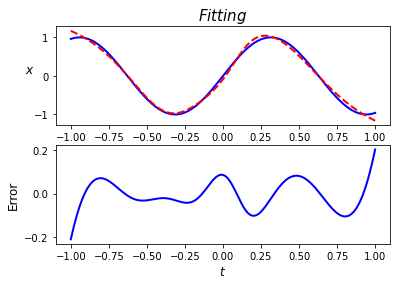

In [25]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    

ax = plt.subplot(211)
ax.plot(t_intp, x_intp, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(t_intp, x_pred, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$t$', fontsize = 12)
ax.set_ylabel('$x$', fontsize = 12, rotation = 0)
ax.set_title('$Fitting$', fontsize = 15)


ax = plt.subplot(212)
ax.plot(t_intp, x_intp-x_pred, 'b-', linewidth = 2)
ax.set_xlabel('$t$', fontsize = 12)
ax.set_ylabel('Error', fontsize = 12, rotation = 90)